# Clustering and Dimensionality Reduction - Coffee quality variety

## 1. Descrição do Dataset

#### Dataset: Coffee Quality Dataset - Arabica Clean

- **Objetivo**: Realizar clusterização de cafés (avaliação da qualidade de grãos de café) com base em atributos físicos e sensoriais.
- **Aplicabilidade**: Segmentação de amostras por perfil sensorial para apoiar decisões comerciais e de produção.


- **Desenvolvimento do trabalho:**: Como o conjunto de dados de alta dimensionalidade (41 atributos), aplicaremos técnicas de redução de dimensionalidade (PCA, t-SNE) para posteriormente para melhorar a visualização e a performance dos algoritmos de clusterização não supervisionada.

---


## 2. Tratamento dos Dados

- Imports

In [1]:
# imports
import pandas as pd
import os.path
import numpy as np
from dateutil import parser
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import kagglehub
from kagglehub import KaggleDatasetAdapter
from types import SimpleNamespace


In [2]:
path = kagglehub.dataset_download("fatihb/coffee-quality-data-cqi")
print("Path to dataset files:", path)
raw = pd.read_csv(os.path.join(path, '/kaggle/input/coffee-quality-data-cqi/df_arabica_clean.csv'))  # ou o nome correto
dataset = raw

Path to dataset files: /kaggle/input/coffee-quality-data-cqi


- Verificação de informações gerais e características do dataset.  

In [3]:
dataset.head()

,Unnamed: 0,ID,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,...,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects,Expiration,Certification Body,Certification Address,Certification Contact
0,0,0,Colombia,Finca El Paraiso,CQU2022015,Finca El Paraiso,NaN,Coffee Quality Union,1700-1930,"Piendamo,Cauca",...,89.33,11.8,0,0,green,3,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
1,1,1,Taiwan,Royal Bean Geisha Estate,"The 2022 Pacific Rim Coffee Summit,T037",Royal Bean Geisha Estate,NaN,Taiwan Coffee Laboratory,1200,Chiayi,...,87.58,10.5,0,0,blue-green,0,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
2,2,2,Laos,OKLAO coffee farms,"The 2022 Pacific Rim Coffee Summit,LA01",oklao coffee processing plant,NaN,Taiwan Coffee Laboratory,1300,Laos Borofen Plateau,...,87.42,10.4,0,0,yellowish,2,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
3,3,3,Costa Rica,La Cumbre,CQU2022017,La Montana Tarrazu MIll,NaN,Coffee Quality Union,1900,"Los Santos,Tarrazu",...,87.17,11.8,0,0,green,0,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
4,4,4,Colombia,Finca Santuario,CQU2023002,Finca Santuario,NaN,Coffee Quality Union,1850-2100,"Popayan,Cauca",...,87.08,11.6,0,2,yellow-green,2,"March 5th, 2024",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901


In [11]:
# Features metadata
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country of Origin     207 non-null    object 
 1   Altitude              207 non-null    float64
 2   Variety               207 non-null    object 
 3   Processing Method     207 non-null    object 
 4   Aroma                 207 non-null    float64
 5   Flavor                207 non-null    float64
 6   Aftertaste            207 non-null    float64
 7   Acidity               207 non-null    float64
 8   Body                  207 non-null    float64
 9   Balance               207 non-null    float64
 10  Overall               207 non-null    float64
 11  Total Cup Points      207 non-null    float64
 12  Moisture Percentage   207 non-null    float64
 13  Category One Defects  207 non-null    int64  
 14  Quakers               207 non-null    int64  
 15  Color                 2

In [13]:
# Target Info
display('Tipos de Variedade de café: ', dataset['Variety'].values)

'Tipos de Variedade de café: '

array(['Other', 'Gesha', 'Java', 'Gesha', 'Other', 'Gesha', 'Gesha',
       'Blend', 'SL34', 'Bourbon', 'Ethiopian Heirlooms', 'Gesha',
       'Gesha', 'Gesha', 'Caturra', 'SL34', 'Blend', 'Gesha', 'Gesha',
       'Bourbon', 'Gesha', 'Typica', 'Catimor', 'Other', 'SL34', 'Other',
       'Gesha', 'Gesha', 'Gesha', 'Typica', 'Typica', 'Typica', 'Gesha',
       'Ethiopian Heirlooms', 'Ethiopian Heirlooms',
       'Ethiopian Heirlooms', 'Gesha', 'Gesha', 'SL28', 'Gesha', 'Typica',
       'Typica', 'Gesha', 'SL14', 'Typica', 'Gesha', 'Caturra', 'Catuai',
       'Caturra', 'Typica', 'Yellow Bourbon', 'Catimor', 'Gesha',
       'Bourbon', 'SL34', 'SL34', 'Yellow Bourbon', 'Catuai',
       'Yellow Bourbon', 'Caturra', 'Bourbon', 'Caturra', 'Typica',
       'Gesha', 'Other', 'Gesha', 'SL34', 'Catimor', 'Gesha', 'unknown',
       'Catuai', 'Ethiopian Heirlooms', 'Typica', 'Gesha', 'Bourbon',
       'Catuai', 'Ethiopian Heirlooms', 'Pacamara', 'Blend', 'Blend',
       'Typica', 'Bourbon', 'Catuai

- Conversão e limpeza de colunas irrelevantes (como Owner, Region, etc.).

In [4]:
# Drop columns unrelated to the production method or beverage characteristics, or those with the same value for all records
columns_to_drop = ['ID','ICO Number','Owner','Region','Certification Contact','Certification Address','Farm Name',"Lot Number","Mill","ICO Number","Producer",'Company','Expiration', 'Harvest Year',
                   "Unnamed: 0",'Number of Bags','Bag Weight','In-Country Partner','Grading Date','Status','Defects','Uniformity','Clean Cup','Sweetness','Certification Body']
dataset.drop(columns_to_drop, axis=1, inplace=True)

In [5]:
# Replace coffee processing methods with only three categories and handle missing values
processing_mapping = {
    "Double Anaerobic Washed": "Washed / Wet",
    "Semi Washed": "Washed / Wet",
    "Honey,Mossto": "Pulped natural / honey",
    "Double Carbonic Maceration / Natural": "Natural / Dry",
    "Wet Hulling": "Washed / Wet",
    "Anaerobico 1000h": "Washed / Wet",
    "SEMI-LAVADO": "Natural / Dry",
    np.nan: "Washed / Wet"
}


dataset['Processing Method'] = dataset['Processing Method'].replace(processing_mapping)
dataset['Processing Method'].fillna("Washed / Wet", inplace=True)

- Mapping para redução de 41 para 20 categorias de café.dataset['Processing Method'].value_counts()

<ipython-input-5-30d4433fedce>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Processing Method'].fillna("Washed / Wet", inplace=True)


,count
Processing Method,
Washed / Wet,133
Natural / Dry,48
Pulped natural / honey,26


In [6]:
# Mapping para redução de 41 para 20 categorias de café.
# Criando duas categorias novas, Blend para misturas e Other (agrupando menos frequentes)

processing_mapping_variety = {"Santander" : "Other",
                      "Typica Gesha" : "Other",
                      "Catucai" : "Catuai" ,
                      "Yellow Catuai" : "Catuai",
                      "SL28,SL34,Ruiru11" : "Blend",
                      "Caturra-Catuai" : "Blend",
                      "Typica Bourbon Caturra Catimor" : "Blend",
                      "Caturra,Colombia,Castillo" : "Blend",
                      "Castillo,Caturra,Bourbon" : "Blend",
                      "unknow" : "unknown",
                      "Bourbon, Catimor, Caturra, Typica" : "Blend",
                      "Pacas" : "Other",
                      "Gayo" : "Other",
                      "Castillo" : "Other",
                      "Lempira" : "Other",
                      "MARSELLESA, CATUAI, CATURRA & MARSELLESA, ANACAFE 14, CATUAI" : "Blend",
                      "Typica + SL34" : "Blend",
                      "Catimor,Catuai,Caturra,Bourbon" : "Blend",
                      "Bourbon Sidra" : "Other",
                      "BOURBON, CATURRA Y CATIMOR" : "Blend",
                      "Jember,TIM-TIM,Ateng": "Blend",
                      "Castillo and Colombia blend" : "Blend",
                      "Catrenic" : "Other",
                      "Castillo Paraguaycito" : "Other",
                      "Wolishalo,Kurume,Dega" : "Blend",
                      "Sl34+Gesha" : "Blend",
                      "Red Bourbon" : "Other",
                      "Catuai and Mundo Novo" : "Blend",
                      "Red Bourbon,Caturra" : "Blend",
                       np.nan: "Other" }
dataset['Variety'] = dataset['Variety'].replace(processing_mapping_variety)

dataset['Variety'].value_counts()

,count
Variety,
Gesha,27
Caturra,27
Typica,23
Bourbon,17
Other,16
Blend,16
Catuai,14
unknown,13
Catimor,11


- Análise e preenchimento de valores ausentes

In [7]:
def clean_altitude_range(range_value):
    if isinstance(range_value, str):
        range_value = range_value.replace(" ", "")
        if '-' in range_value:
            try:
                start, end = range_value.split('-')
                start = int(start)
                end = int(end)
                return (start + end) / 2
            except ValueError:
                return np.nan
        else:
            try:
                return int(range_value)
            except ValueError:
                return np.nan
    else:
        return range_value

dataset['Altitude'] = dataset['Altitude'].apply(clean_altitude_range)

In [8]:
# Preenchendo ausentes com a mediana
dataset.fillna({'Altitude': dataset['Altitude'].median()}, inplace=True)

## 3. Análise Exploratória - EDA

- Análise estatística de variáveis.  
- Verificação de correlações.  
- Distribuição de variáveis sensoriais.  
- Visualização com histogramas.

In [16]:
# Estatistica basica
dataset.describe()

,Altitude,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Overall,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Category Two Defects
count,207.000000,207.000000,207.000000,207.000000,207.00000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000
mean,1292.025362,7.721063,7.744734,7.599758,7.69029,7.640918,7.644058,7.676812,83.706570,10.735266,0.135266,0.690821,2.251208
std,664.425600,0.287626,0.279613,0.275911,0.25951,0.233499,0.256299,0.306359,1.730417,1.247468,0.592070,1.686918,2.950183
min,139.000000,6.500000,6.750000,6.670000,6.83000,6.830000,6.670000,6.670000,78.000000,0.000000,0.000000,0.000000,0.000000
25%,1020.000000,7.580000,7.580000,7.420000,7.50000,7.500000,7.500000,7.500000,82.580000,10.100000,0.000000,0.000000,0.000000
50%,1301.250000,7.670000,7.750000,7.580000,7.67000,7.670000,7.670000,7.670000,83.750000,10.800000,0.000000,0.000000,1.000000
75%,1600.000000,7.920000,7.920000,7.750000,7.87500,7.750000,7.790000,7.920000,84.830000,11.500000,0.000000,1.000000,3.000000
max,5400.000000,8.580000,8.500000,8.420000,8.58000,8.250000,8.420000,8.580000,89.330000,13.500000,5.000000,12.000000,16.000000


In [9]:
numeric_attributes = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall', 'Total Cup Points', 'Moisture Percentage']

# Create a subplot for each numeric attribute
fig = make_subplots(rows=len(numeric_attributes), cols=1)

# Add a histogram to the subplot for each numeric attribute
for i, attribute in enumerate(numeric_attributes):
    fig.add_trace(go.Histogram(x=dataset[attribute], nbinsx=50, name=attribute), row=i+1, col=1)

fig.update_layout(height=200*len(numeric_attributes), width=800, title_text="Histograms of Numeric Attributes")
fig.show()

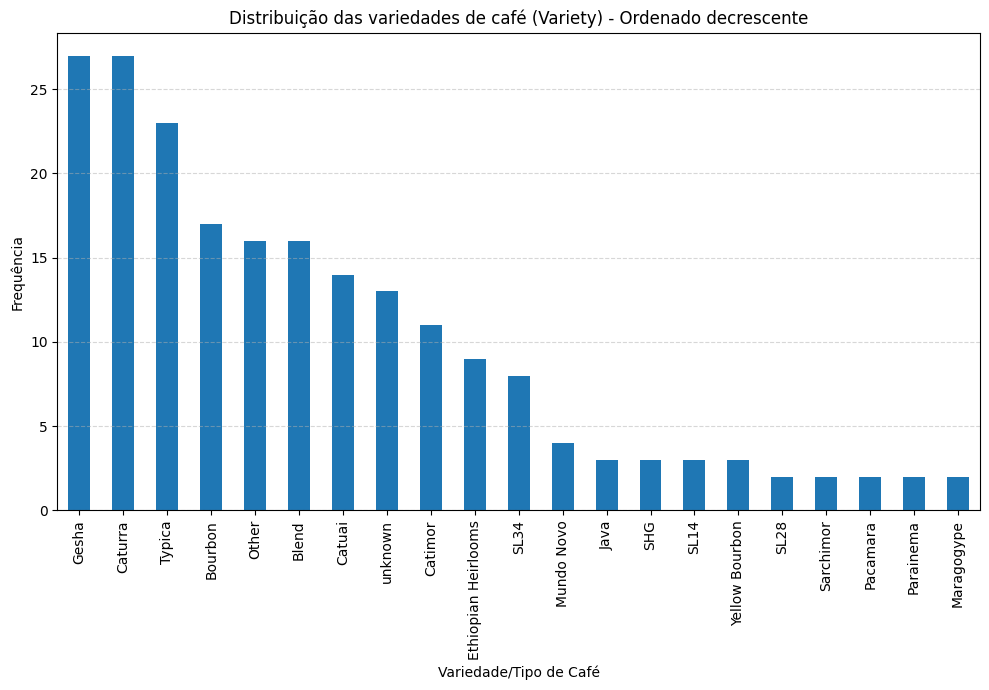

In [20]:
# Distribuição das variedades de café (frequência) - ver se está bem balanceada
plt.figure(figsize=(10,7))
dataset['Variety'].value_counts().plot(kind='bar')
plt.title('Distribuição das variedades de café (Variety) - Ordenado decrescente')
plt.ylabel('Frequência')
plt.xlabel('Variedade/Tipo de Café')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 4. Pré-processamento

- Encoding de variáveis categóricas (LabelEncoder).
- Padronização com StandardScaler.
- Remoção de colunas com alta multicolinearidade.  

In [ ]:
le = LabelEncoder()
categorical_features = ['Country of Origin', 'Processing Method', 'Color', 'Variety']
for feature in categorical_features:
    dataset[feature] = le.fit_transform(dataset[feature])

mm = StandardScaler()
numerical_features = ['Altitude', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall', 'Total Cup Points', 'Moisture Percentage', 'Category One Defects', 'Quakers', 'Category Two Defects']
for feature in numerical_features:
    dataset[feature] = mm.fit_transform(dataset[feature].values.reshape(-1,1))

In [ ]:
dataset

,Country of Origin,Altitude,Variety,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Overall,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects
0,1,0.789016,10,2,2.993534,2.707661,2.980060,3.436732,2.614819,3.034825,2.955285,3.257632,0.855585,-0.229016,-0.410510,4,0.254427
1,16,-0.138839,6,2,2.714721,2.707661,1.163485,1.196334,1.198113,2.369929,2.693520,2.243864,-0.189052,-0.229016,-0.410510,0,-0.764924
2,9,0.012031,7,2,2.122244,2.420858,1.744789,1.853003,1.198113,2.057037,2.137270,2.151176,-0.269408,-0.229016,-0.410510,11,-0.085356
3,2,0.917256,6,2,1.250954,1.524596,2.071773,2.162023,2.271375,1.705034,1.875506,2.006352,0.855585,-0.229016,-0.410510,4,-0.764924
4,1,1.030409,10,1,2.122244,2.098204,1.744789,2.162023,1.198113,1.079250,1.875506,1.954216,0.694872,-0.229016,0.777959,10,-0.085356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0,-0.516016,9,0,-1.920542,-2.060448,-2.469664,-2.009752,-0.948411,-1.854111,-1.952802,-2.100859,0.534158,-0.229016,-0.410510,4,0.594211
203,13,-0.138839,13,0,-1.362917,-2.383102,-3.087299,-2.009752,-0.948411,-1.854111,-1.952802,-2.147202,-0.269408,-0.229016,0.777959,4,3.312481
204,9,0.012031,2,2,-1.641729,-2.060448,-1.888360,-2.666420,-2.408048,-2.206115,-2.214567,-2.338370,0.694872,-0.229016,4.937598,4,2.972698
205,3,-0.138839,8,0,-4.255600,-3.566167,-3.087299,-2.009752,-2.408048,-2.519006,-2.770817,-3.259451,0.212732,-0.229016,6.720300,1,3.652265


In [ ]:
y = dataset["Variety"].copy()
X = dataset.drop(columns=["Variety"])

In [ ]:
X

,Country of Origin,Altitude,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Overall,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects
0,1,0.789016,2,2.993534,2.707661,2.980060,3.436732,2.614819,3.034825,2.955285,3.257632,0.855585,-0.229016,-0.410510,4,0.254427
1,16,-0.138839,2,2.714721,2.707661,1.163485,1.196334,1.198113,2.369929,2.693520,2.243864,-0.189052,-0.229016,-0.410510,0,-0.764924
2,9,0.012031,2,2.122244,2.420858,1.744789,1.853003,1.198113,2.057037,2.137270,2.151176,-0.269408,-0.229016,-0.410510,11,-0.085356
3,2,0.917256,2,1.250954,1.524596,2.071773,2.162023,2.271375,1.705034,1.875506,2.006352,0.855585,-0.229016,-0.410510,4,-0.764924
4,1,1.030409,1,2.122244,2.098204,1.744789,2.162023,1.198113,1.079250,1.875506,1.954216,0.694872,-0.229016,0.777959,10,-0.085356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0,-0.516016,0,-1.920542,-2.060448,-2.469664,-2.009752,-0.948411,-1.854111,-1.952802,-2.100859,0.534158,-0.229016,-0.410510,4,0.594211
203,13,-0.138839,0,-1.362917,-2.383102,-3.087299,-2.009752,-0.948411,-1.854111,-1.952802,-2.147202,-0.269408,-0.229016,0.777959,4,3.312481
204,9,0.012031,2,-1.641729,-2.060448,-1.888360,-2.666420,-2.408048,-2.206115,-2.214567,-2.338370,0.694872,-0.229016,4.937598,4,2.972698
205,3,-0.138839,0,-4.255600,-3.566167,-3.087299,-2.009752,-2.408048,-2.519006,-2.770817,-3.259451,0.212732,-0.229016,6.720300,1,3.652265


## 5. Redução de Dimensionalidade

#### Aplicando PCA (Principal Component Analysis):
- Avaliação de variância explicada.  

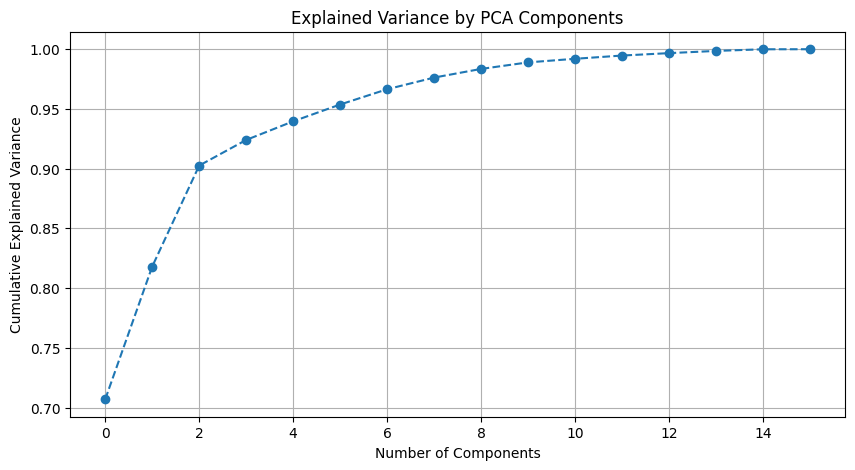

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

- Visualização dos dados em 2D.

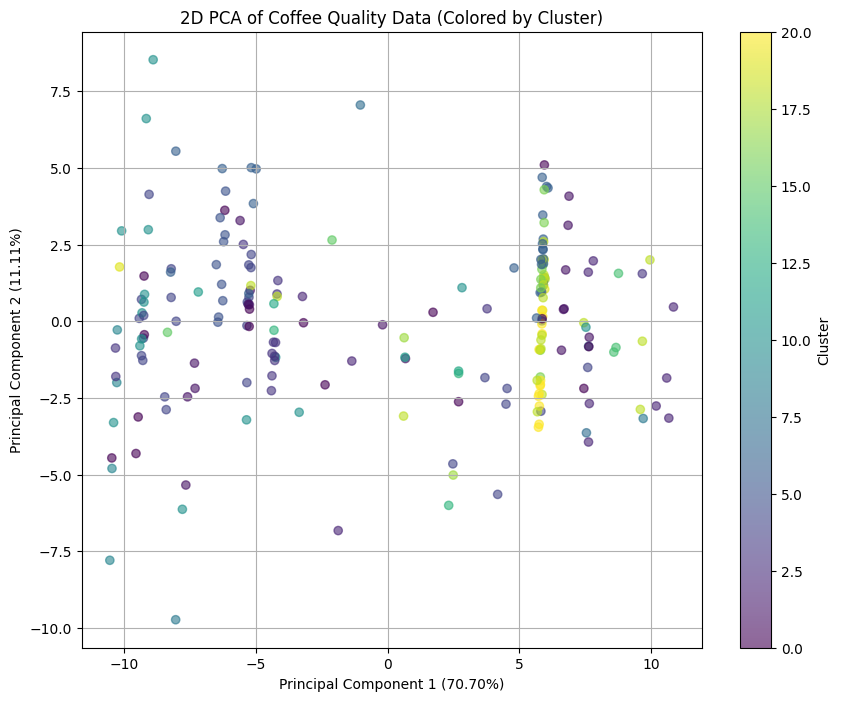

In [ ]:
# Reduce to 2 components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

# Create a DataFrame for plotting
import pandas as pd
pca_df = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
pca_df['cluster'] = y

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1 (%.2f%%)' % (pca_2d.explained_variance_ratio_[0] * 100))
plt.ylabel('Principal Component 2 (%.2f%%)' % (pca_2d.explained_variance_ratio_[1] * 100))
plt.title('2D PCA of Coffee Quality Data (Colored by Cluster)')
plt.colorbar(scatter, label='Cluster')
plt.grid()
plt.show()

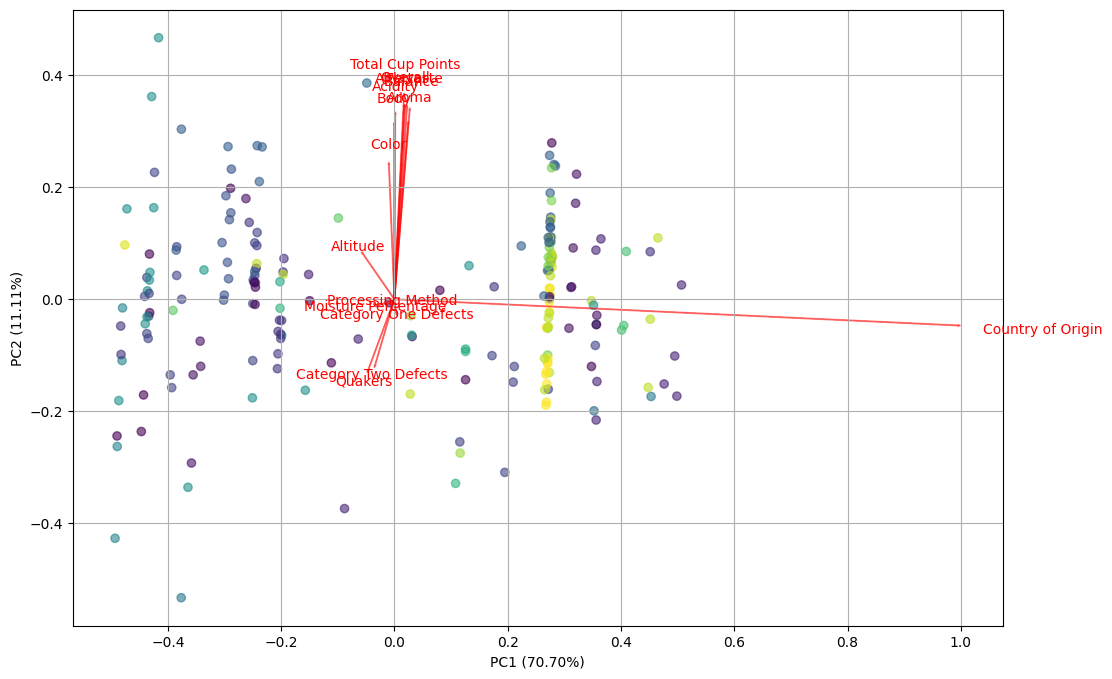

In [ ]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(12, 8))
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, c=y, cmap='viridis', alpha=0.6)

    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='red', alpha=0.5)
        plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='red', ha='center', va='center')

    plt.xlabel('PC1 (%.2f%%)' % (pca_2d.explained_variance_ratio_[0] * 100))
    plt.ylabel('PC2 (%.2f%%)' % (pca_2d.explained_variance_ratio_[1] * 100))
    plt.grid()

# Call the function (replace `feature_names` with your column names)
biplot(X_pca_2d, np.transpose(pca_2d.components_), labels=X.columns)

Hiperparametrizacao: Metodo do Cotovelo - KMeans

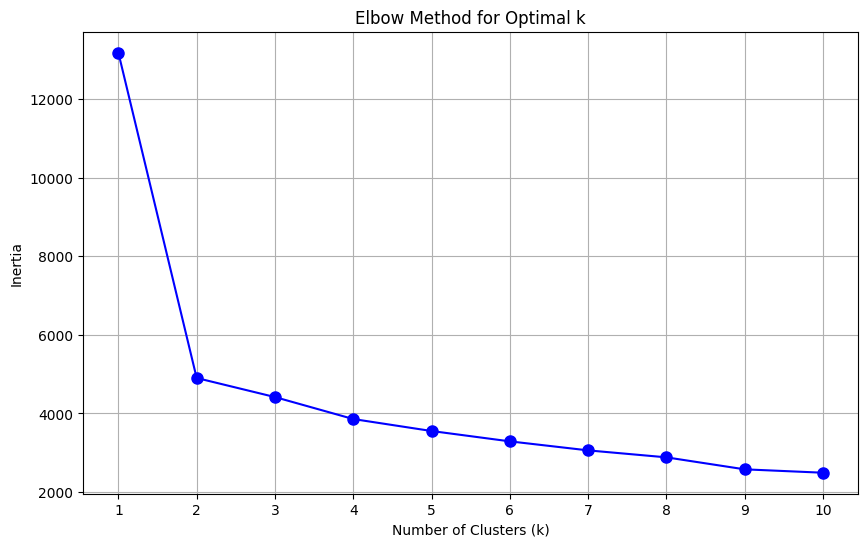

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming X_pca is your PCA-reduced data (or use X_scaled for raw features)
inertia = []
k_range = range(1, 11)  # Test k from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)  # Replace with X_scaled if not using PCA
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid()
plt.show()

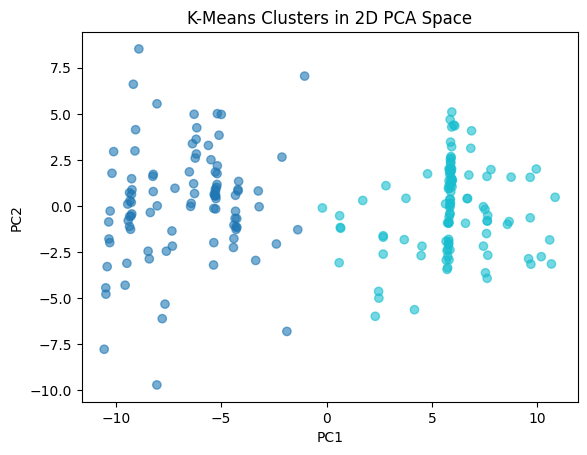

In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means to PCA-reduced data
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca[:, :2])  # Use first 2 PCs

# Plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clusters in 2D PCA Space')
plt.show()

Avaliação do KMeans em após redução PCA com Silhouette_Score

In [ ]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):  # k starts at 2 (silhouette needs ≥2 clusters)
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    print(f"k={k}: Silhouette Score = {score:.3f}")

k=2: Silhouette Score = 0.538
k=3: Silhouette Score = 0.340
k=4: Silhouette Score = 0.208
k=5: Silhouette Score = 0.217
k=6: Silhouette Score = 0.226
k=7: Silhouette Score = 0.237
k=8: Silhouette Score = 0.198
k=9: Silhouette Score = 0.238
k=10: Silhouette Score = 0.208


## Resultado dos Clusters (melhor Silhouette e melhor Elbow - k=2)

In [ ]:
# Add cluster labels to your original DataFrame
dataset['cluster'] = clusters  # From K-Means (0 and 1)

# Group by cluster and compute mean values
cluster_profile = dataset.groupby('cluster').mean(numeric_only=True)

cluster_profile[numerical_features]

,Altitude,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Overall,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Category Two Defects
cluster,,,,,,,,,,,,,
0,0.455751,-0.138799,-0.079064,-0.091637,0.038703,0.052267,-0.121109,-0.061755,-0.060601,0.196163,-0.106835,0.336878,0.268439
1,-0.401890,0.122395,0.069720,0.080807,-0.034129,-0.046090,0.106797,0.054457,0.053439,-0.172980,0.094209,-0.297065,-0.236715


#### Aplicando t-SNE:

In [ ]:
# Dimensionality reduction
from sklearn.manifold import TSNE  # For t-SNE implementation
import plotly.express as px  # For interactive plotting

tsne = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200)
tsne_results = tsne.fit_transform(X)

# Plotly Interactive plot
df_tsne = pd.DataFrame(data = tsne_results, columns = ['Dim_1', 'Dim_2'])
df_tsne['Variety'] = dataset['Variety']
fig = px.scatter(df_tsne, x='Dim_1', y='Dim_2', color='Variety', title='t-SNE plot colored by Variety')
fig.show()

In [ ]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):  # k starts at 2 (silhouette needs ≥2 clusters)
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(tsne_results)
    score = silhouette_score(tsne_results, labels)
    print(f"k={k}: Silhouette Score = {score:.3f}")

k=2: Silhouette Score = 0.820
k=3: Silhouette Score = 0.575
k=4: Silhouette Score = 0.388
k=5: Silhouette Score = 0.412
k=6: Silhouette Score = 0.419
k=7: Silhouette Score = 0.422
k=8: Silhouette Score = 0.409
k=9: Silhouette Score = 0.418
k=10: Silhouette Score = 0.433


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
df_tsne['KMeans_Cluster'] = kmeans.fit_predict(tsne_results)

In [ ]:
for k in range(2, 11):  # k starts at 2 (silhouette needs ≥2 clusters)
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(tsne_results)
    score = silhouette_score(tsne_results, labels)
    print(f"k={k}: Silhouette Score = {score:.3f}")

k=2: Silhouette Score = 0.820
k=3: Silhouette Score = 0.564
k=4: Silhouette Score = 0.370
k=5: Silhouette Score = 0.370
k=6: Silhouette Score = 0.399
k=7: Silhouette Score = 0.386
k=8: Silhouette Score = 0.390
k=9: Silhouette Score = 0.407
k=10: Silhouette Score = 0.413


Dendrograma (best k=2)

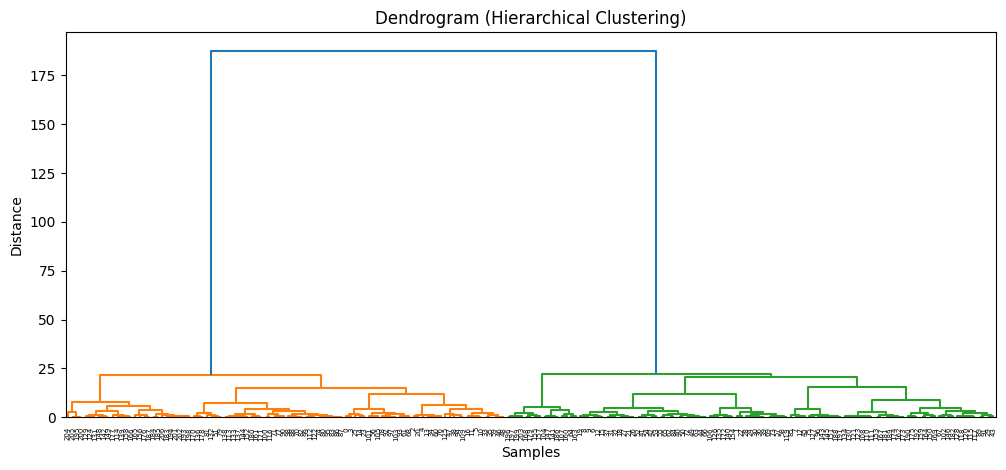

In [ ]:
# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
df_tsne['Hierarchical_Cluster'] = agg.fit_predict(tsne_results)

# Optional: Plot Dendrogram
plt.figure(figsize=(12, 5))
dendrogram(linkage(tsne_results, method='ward'))
plt.title('Dendrogram (Hierarchical Clustering)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

Otimização DBScan

In [ ]:
from sklearn.metrics import silhouette_score

# Define parameter ranges
eps_values = np.linspace(1.0, 5.0, 10)  # Adjust based on k-distance plot
min_samples_values = range(3, 10)

best_score = -1
best_params = {'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(tsne_results)

        # Skip if all points are noise or only one cluster
        if len(np.unique(labels)) > 1 and len(np.unique(labels)) < len(tsne_results):
            score = silhouette_score(tsne_results, labels)
            if score > best_score:
                best_score = score
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

print(f"Best parameters: eps={best_params['eps']:.2f}, min_samples={best_params['min_samples']}")
print(f"Best Silhouette Score: {best_score:.3f}")

Best parameters: eps=2.33, min_samples=3
Best Silhouette Score: 0.820


In [ ]:
dbscan_opt = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
df_tsne['DBSCAN_Cluster'] = dbscan_opt.fit_predict(tsne_results)

# Count clusters and noise
n_clusters = len(np.unique(df_tsne['DBSCAN_Cluster'])) - (1 if -1 in df_tsne['DBSCAN_Cluster'] else 0)
n_noise = (df_tsne['DBSCAN_Cluster'] == -1).sum()
print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise}")

Clusters found: 2
Noise points: 0


Resultado DBscan otimizado (k=2)

In [ ]:
import plotly.express as px

fig = px.scatter(df_tsne, x='Dim_1', y='Dim_2',
                 color='DBSCAN_Cluster',
                 color_continuous_scale='rainbow',
                 title=f'DBSCAN Clusters (eps={best_params["eps"]:.2f}, min_samples={best_params["min_samples"]})')
fig.show()

Resultados PCA, t-SNE, Otimização DBscan: BEST K = 2

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('K-Means', 'Hierarchical', 'DBSCAN'))

# K-Means Plot
fig.add_trace(
    go.Scatter(
        x=df_tsne['Dim_1'], y=df_tsne['Dim_2'],
        mode='markers',
        marker=dict(color=df_tsne['KMeans_Cluster'], colorscale='viridis')
    ),
    row=1, col=1
)

# Hierarchical Plot
fig.add_trace(
    go.Scatter(
        x=df_tsne['Dim_1'], y=df_tsne['Dim_2'],
        mode='markers',
        marker=dict(color=df_tsne['Hierarchical_Cluster'], colorscale='plasma')
    ),
    row=1, col=2
)

# DBSCAN Plot
fig.add_trace(
    go.Scatter(
        x=df_tsne['Dim_1'], y=df_tsne['Dim_2'],
        mode='markers',
        marker=dict(color=df_tsne['DBSCAN_Cluster'], colorscale='rainbow')
    ),
    row=1, col=3
)

fig.update_layout(height=500, width=1200, title_text="Clustering Comparison on t-SNE")
fig.show()

In [ ]:
# Add cluster labels to your original DataFrame
dataset['cluster_tsne_db_scan'] = df_tsne["DBSCAN_Cluster"]

# Group by cluster and compute mean values
cluster_profile = dataset.groupby('cluster_tsne_db_scan').mean(numeric_only=True)

cluster_profile[numerical_features]

,Altitude,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Overall,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Category Two Defects
cluster_tsne_db_scan,,,,,,,,,,,,,
0,0.454302,-0.130308,-0.071846,-0.091434,0.040661,0.049066,-0.118838,-0.056010,-0.056770,0.205352,-0.108082,0.329251,0.257895
1,-0.408455,0.117157,0.064595,0.082207,-0.036558,-0.044114,0.106845,0.050358,0.051041,-0.184628,0.097174,-0.296024,-0.231869


## CONCLUSÃO (2 clusters: Good coffee and Bad coffee)

### **Coffee Quality Clusters Analysis**  

#### **🔵 Cluster 0 - Commercial Grade**  
| Feature                | Z-score | Interpretation                          | Impact                          |
|------------------------|---------|-----------------------------------------|----------------------------------|
| **Altitude**           | +0.45   | Moderately high (~1300-1500m)           | Average bean density            |
| **Aroma**              | -0.13   | Less pronounced aromas                  | Simpler fragrance profile       |
| **Flavor**             | -0.07   | Straightforward taste                   | Reduced complexity              |
| **Moisture**           | +0.21   | Slightly high (>12%)                    | Risk of storage issues          |
| **Quakers**            | +0.33   | Noticeable immature beans               | Potential bitter notes          |
| **Category Two Defects**| +0.26  | 5-15 defects/300g                      | Visual quality concerns         |

**Key Notes**:  
- 🏭 **Typical Origin**: Bulk production, variable processing  
- ⚠️ **Main Risks**: Moisture control and defect management  
- ✅ **Improvement Path**:  
  - Implement stricter drying protocols  
  - Enhanced sorting for quakers  

#### **🟢 Cluster 1 - Premium Grade**  
| Feature                | Z-score | Interpretation                          | Advantage                       |
|------------------------|---------|-----------------------------------------|----------------------------------|
| **Altitude**           | -0.41   | Lower elevation (~900-1200m)            | Compensated by processing       |
| **Aroma**              | +0.12   | Clean, vibrant aromatics                | Distinctive character           |
| **Flavor**             | +0.06   | Well-balanced profile                   | Pleasant aftertaste             |
| **Moisture**           | -0.18   | Tightly controlled (10-11%)             | Stable shelf life               |
| **Quakers**            | -0.30   | Minimal immature beans                  | Flavor consistency              |
| **Category Two Defects**| -0.23  | 3-5 defects/300g                       | Excellent visual standards      |

**Key Notes**:  
- 🌿 **Typical Origin**: Specialty lots, careful processing  
- 💎 **Strengths**: Processing quality overcomes altitude limitations  
- 📈 **Market Position**: Ideal for specialty branding  

### **🔎 Key Observations**  
1. **Process > Altitude**: Superior processing can compensate for lower elevations  
2. **Moisture Matters**: Just +0.21 Z-score difference creates significant quality gap  
3. **Quakers Are Critical**: 0.63 Z-score spread shows sorting importance  

### **📌 Recommended Actions**  
- **For Cluster 0**: Focus on post-harvest control (drying/sorting)  
- **For Cluster 1**: Market as "process-perfected" specialty coffee  
- **For Both**: Monitor quakers as key quality indicator  